In [1]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator, Aer
from qiskit.providers.fake_provider import FakeProvider, FakeManila, FakeToronto, FakeJakartaV2
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import QDrift, LieTrotter, SuzukiTrotter
import qiskit.quantum_info as qi
import qiskit
from qiskit.visualization import plot_histogram

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing as skp
from scipy.signal import savgol_filter
import scipy
import os
import sys
import itertools
from numpy.random import Generator, PCG64
from datetime import date
import pathlib
import inspect
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..'))
plot_path = f'{module_path}/plots'
sys.path.insert(0, os.path.abspath('../src/'))

from feedforward import QExtremeLearningMachine
from rewinding import QRewindingRC, QRewindingStatevectorRC
from data import DataSource

from noisemodel import thermal_model


In [9]:
data = DataSource()
rnn = QRewindingStatevectorRC(restarting=True, log=False)
rnn.run(data)

print(rnn.mse_val)

9.262586602279926


In [11]:
data = DataSource()
rnn = QRewindingStatevectorRC(restarting=True, sim_sampling='naive', log=False)
rnn.run(data)

print(rnn.mse_val)

3.1066220293690106


# Statevector / density matrix simulations over nqubits

sampling counts from the statevector is the problem

In [ ]:
from circuits import ising_circuit

shots = 2**13
nmeas = 2
qmeas = [*range(nmeas)]
nqubits_list = [*range(nmeas, 10)]
navg = 5

df = pd.DataFrame()
df['nqubits'] = nqubits_list

In [ ]:
def time_method(name, backend):
    total_times = np.zeros(shape=(len(nqubits_list),))
    transpile_times = np.zeros(shape=(len(nqubits_list),))
    run_times = np.zeros(shape=(len(nqubits_list),))

    for cnt, nqubits in enumerate(nqubits_list):
        for _ in range(navg):
            qmeas = [*range(nqubits)]
            qc = QuantumCircuit(nqubits, nqubits)
            qc.append(ising_circuit(nqubits=nqubits), qargs=qmeas)
            qc.measure(qmeas, qmeas)

            if backend == 'custom':
                noisemodel = thermal_model(nqubits=nqubits)
                backend = AerSimulator(noise_model=noisemodel)

            #######################
            t0 = time.time()
            compiled_qc = transpile(qc, backend)
            t_transpile = time.time() - t0

            t0_run = time.time()
            job = backend.run(compiled_qc, shots=shots)
            result = job.result() # this takes time
            counts = result.get_counts()
            # sv = result.get_statevector()
            t_run = time.time() - t0_run

            t_total = time.time() - t0

            total_times[cnt] += t_total
            transpile_times[cnt] += t_transpile
            run_times[cnt] += t_run

    df[name] = total_times
    df[name + '_transpile'] = transpile_times
    df[name + '_run'] = run_times

    df.plot(
        x='nqubits', 
        y=[name, name + '_transpile', name + '_run'], 
        linestyle="none", marker="o", title='Measuring scaling number of qubits (all)', ylabel='time [s]')

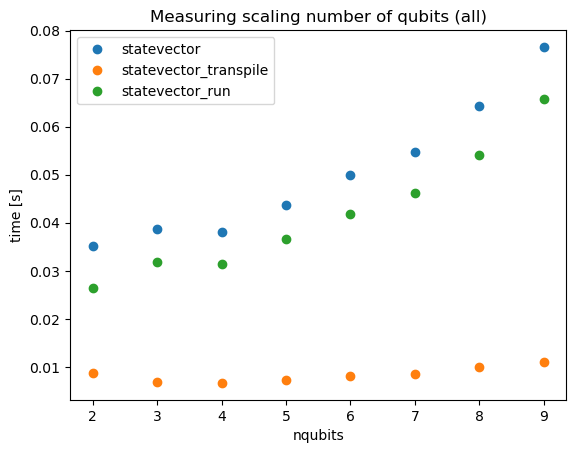

In [ ]:

aer_method = 'statevector'
backend = AerSimulator(method = aer_method)

name = 'statevector'

time_method(name, backend)

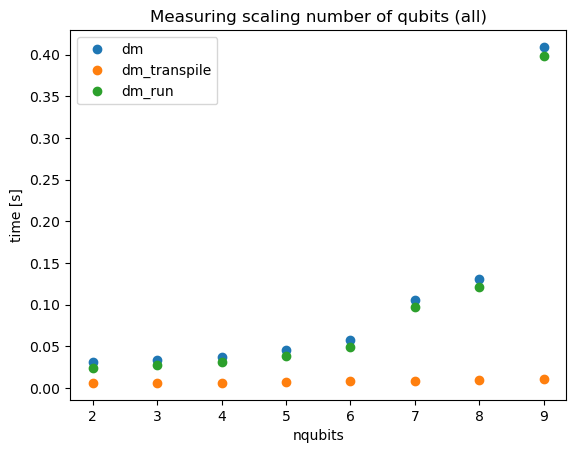

In [ ]:

aer_method = 'density_matrix'
backend = AerSimulator(method = aer_method)

name = 'dm'

time_method(name, backend)

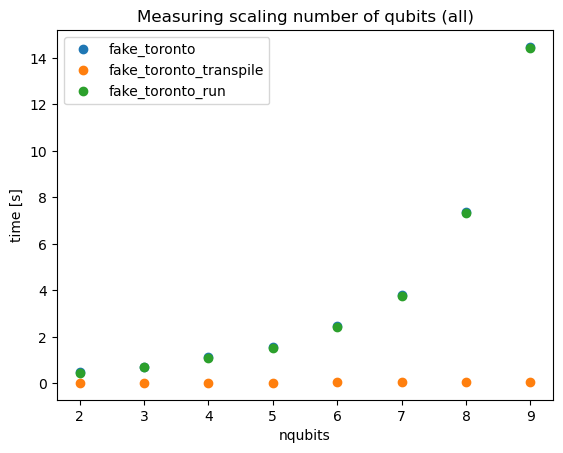

In [ ]:
aer_method = 'statevector'
provider = FakeProvider()
backend = provider.get_backend('fake_toronto')
noise_model = NoiseModel.from_backend(backend)
backend = AerSimulator(method = aer_method, noise_model = noise_model)

name = 'fake_toronto'

time_method(name, backend)

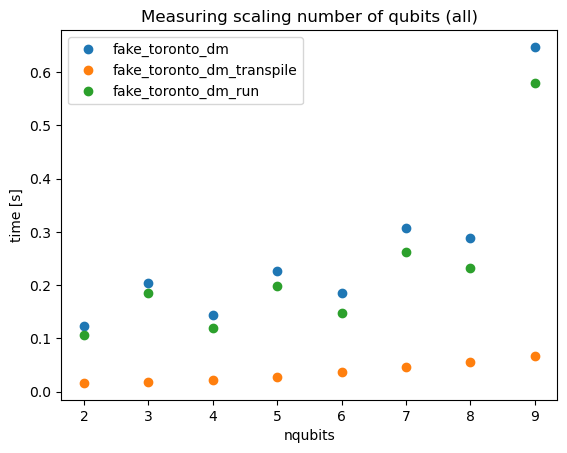

In [ ]:
aer_method = 'density_matrix'
provider = FakeProvider()
backend = provider.get_backend('fake_toronto')
noise_model = NoiseModel.from_backend(backend)
backend = AerSimulator(method = aer_method, noise_model = noise_model)

name = 'fake_toronto_dm'

time_method(name, backend)

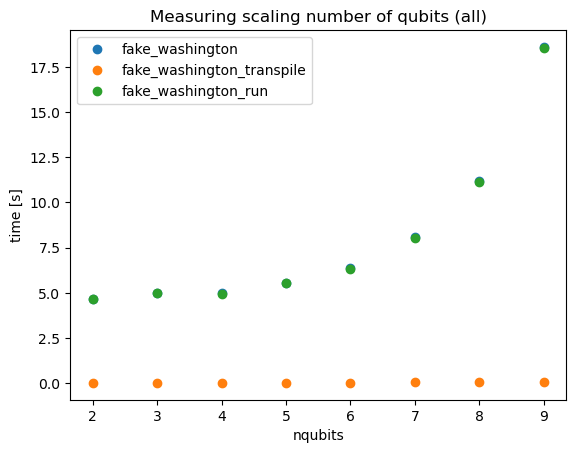

In [ ]:
aer_method = 'statevector'
provider = FakeProvider()
backend = provider.get_backend('fake_washington')
noise_model = NoiseModel.from_backend(backend)
backend = AerSimulator(method = aer_method, noise_model = noise_model)

name = 'fake_washington'


time_method(name, backend)

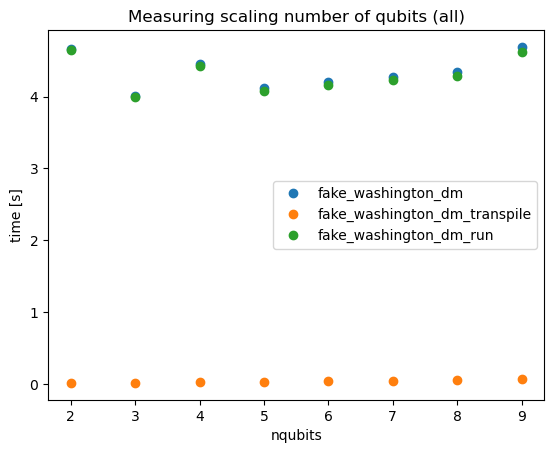

In [ ]:
aer_method = 'density_matrix'
provider = FakeProvider()
backend = provider.get_backend('fake_washington')
noise_model = NoiseModel.from_backend(backend)
backend = AerSimulator(method = aer_method, noise_model = noise_model)

name = 'fake_washington_dm'


time_method(name, backend)

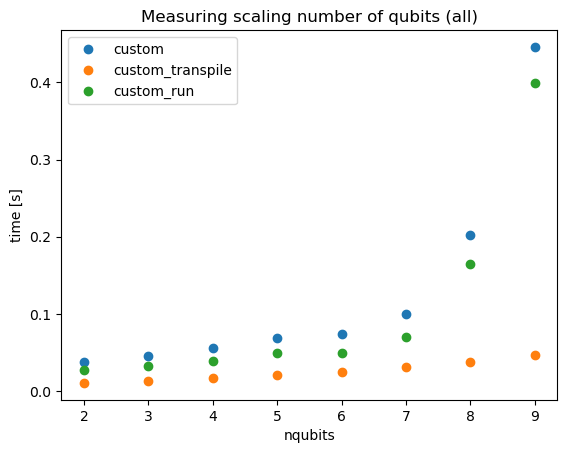

In [ ]:
name = 'custom'

time_method(name, 'custom')

<Axes: title={'center': 'Measuring scaling number of qubits (all)'}, xlabel='nqubits', ylabel='time [s]'>

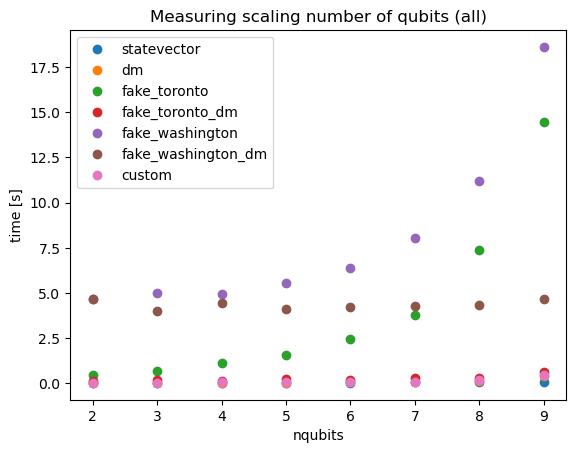

In [ ]:
df.reset_index().plot(
    x='nqubits', 
    y=['statevector', 'dm', 'fake_toronto', 'fake_toronto_dm', 'fake_washington', 'fake_washington_dm', 'custom'],
    linestyle="none", marker="o", title='Measuring scaling number of qubits (all)', ylabel='time [s]'
)

<Axes: title={'center': 'Measuring scaling number of qubits (all)'}, xlabel='nqubits', ylabel='time [s]'>

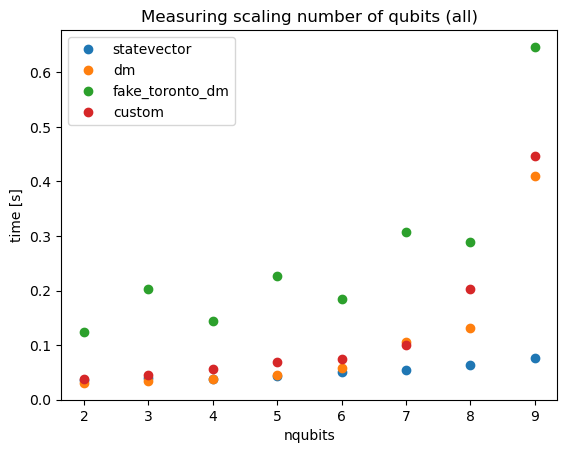

In [ ]:
df.reset_index().plot(
    x='nqubits', 
    y=['statevector', 'dm', 'fake_toronto_dm', 'custom'],
    linestyle="none", marker="o", title='Measuring scaling number of qubits (all)', ylabel='time [s]'
)

<Axes: title={'center': 'Measuring scaling number of qubits (all)'}, xlabel='nqubits', ylabel='time [s]'>

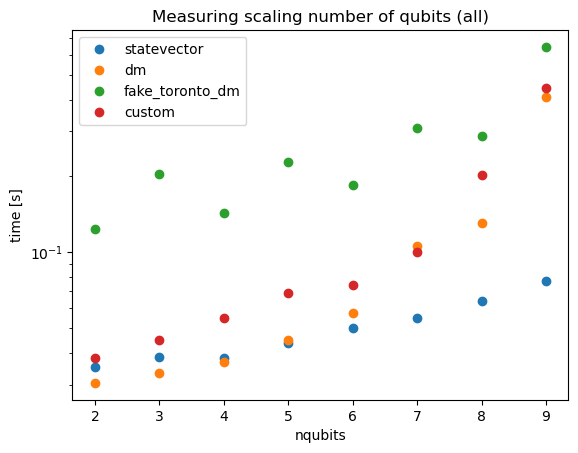

In [ ]:
df.reset_index().plot(
    x='nqubits', 
    y=['statevector', 'dm', 'fake_toronto_dm', 'custom'],
    linestyle="none", marker="o", title='Measuring scaling number of qubits (all)', ylabel='time [s]',
    logy=True,
)